# Air Quality Analysis Ulm, Germany 2022

## Table of Contents
* [Introduction](#section1)
* [Posing Questions](#section2)
* [Data Collection and Wrangling](#section3) 
* [Exploratory Data Analysis](#section4)
    * Statistics
    * Visualizations
* [Time Series Analysis](#section5)

## Introduction <a class="anchor" id="section1"></a>
In recent years the concerns about polluted environments and the damage caused due to toxic emissions from industries, traffic, and growing population increased. 
Among the most common atmospheric pollutants are **carbon monoxide (CO), nitrogen oxides (NO and NO2), ozone (O3) and particulate matter (PM)**, predominantly fine particulate matter (with aerodynamic diameter ≤ 2.5 μm, PM2.5). These pollutants, at certain established concentration levels, can damage respiratory and cardiovascular systems (Pope et al., 2012).

**About the project "airquality and climate data measuring"**

> Within the state funding project Zukunftskommune@bw, 5 LoRaWan-capable air monitoring stations from the company Hawadawa (http://hawadawa.com) were set up at Eselsberg December 2020 in Ulm. These measure ozone, nitrogen oxide and fine dust data, air pressure, humidity. As of 7/12/2021, one more Sensor ("in der Wanne") continues to operate.</br></br>In the period from December 2020 - end of December 2021, 5 LoRaWan-enabled Sentience will provide hourly air quality data at these locations on Eselberg:</br>Lupferbrücke: Corner of Weinbergweg / In der Wanne on the traffic island.</br>
Fort unterer Eselsberg: Footpath (data delivery only until 6.12.2021)</br>
New residential area Am Weinberg: Mähringer Weg 95 (data delivery only until 6.12.2021)</br>
Allotment garden below Lukaskirche next to playground/soccer field (data delivery only until 6.12.2021)</br>
REWE Bunk storefront Trollingerweg 2 (data delivery only until 6.12.2021)

Source: https://www.zukunftsstadt-ulm.de/eselsberg/luft-und-klimamessungen

**General information about air pollutants**
##### NO2
>Nitrogen oxides are by-products of combustion processes. Under solar irradiation, they are decisive for the formation of ground-level ozone and are also a source of particulate matter.

- **Main sources:** Road traffic, furnaces, solvents, agriculture.
- **Health effects:** Irritates and constricts bronchial tubes, intensifies lung disease, increases risk of
diabetes and cardiovascular disease
- **Affected risk groups:** People with lung disease or increased cardiovascular risk, children, seniors, outdoor
active outdoors
- **Effects on the Environment:** Impaired plant growth, overfertilization and acidification of soils and water bodies)
- **Limit values hourly mean:** 200μg/m (EU and WHO limit).
- **Annual average:** 40μg/m (EU and WHO limit)

##### O3
>Ozone is a colorless, toxic gas. Near the ground, it is formed from nitrogen oxides and other volatile organic compounds by photochemical processes in the presence of sunlight. and other volatile organic compounds.

- **Main sources:** Road traffic, combustion plants, solvents, agriculture.
- **Health effects:** Damage to the lungs, intensification of asthma symptoms or other lung diseases, irritation of the respiratory tract
- **Affected risk groups:** People with lung diseases, children, seniors, people active outdoors.
- **Effects on the Environment:** Impaired plant growth, quality and quantity of agricultural products.
- **Limits:** 8h hourly average: 120μg/m (EU target value), 8h hourly average: 100μg/m (WHO limit)

##### PM10
>PM includes all solid and liquid particles of different chemical compositions with a diameter of less than
than 10 μm.

- **Main sources:** Road transport, power plants, residential furnaces/heaters, metal production, agriculture,
Soil erosion.
- **Health effects:** Depending on their size, particles penetrate into the nasal cavity, bronchial tubes or the bloodstream and damage the tissue
- **Affected risk groups:** Persons at increased risk for pulmonary, cardiovascular disease or diabetes, children,
seniors, people active outdoors
- **Limits:** 24-hour average: 50 μg/m (EU and WHO limit), Annual mean: 40 μg/m (EU limit), Annual mean: 20 μg/m (WHO limit)

##### PM2.5
>PM includes all solid and liquid particles of different chemical compositions with a diameter of less than
than 2.5 μm.

- **Main sources:** Road transport, power plants, residential furnaces/heaters, metal production, agriculture, soil erosion
- **Effects on Health:** Depending on size, particles penetrate into nasal cavity, bronchial tubes, or bloodstream and damage tissue
- **Affected risk groups:** Persons at increased risk of pulmonary, cardiovascular disease or diabetes, children, senior citizens, persons active outdoors
- **Limits:** 24-hour average: 25 μg/m (WHO limit), Annual mean: 25 μg/m (EU limit), Annual mean: 10 μg/m (WHO limit)

Source: State Office for the Environment Bavaria and State Office for the Environment Baden Württemberg, Air Quality Monitoring Network Data (Landesamt für Umwelt Bayern und Landesamt für Umwelt Baden Württemberg, Luftqualitätsmessnetzdaten)

## Posing Questions <a class="anchor" id="section2"></a>

Before taking a look at the data, I ask myself some questions I find interesting about air quality data. Below are some interesting topics to explore:</br></br>
&nbsp;1. How are pollutant measures distributed throughout the day?</br>
&nbsp;&nbsp;&nbsp;1.1 Daily/Weekly peak time(s)</br>
&nbsp;&nbsp;&nbsp;1.2 Yearly distribution?</br>
&nbsp;&nbsp;&nbsp;1.3 Peak time(s) throughout the year?</br>
&nbsp;&nbsp;&nbsp;1.4 Are pollutant limits set by WHO exceeded at certain occasions?</br>
&nbsp;&nbsp;&nbsp;1.5 Can certain distributions be attributed to the geolocation of a sensor? Is there a correlation?</br>
&nbsp;2. Are there visible trends or seasonality?</br>
&nbsp;&nbsp;&nbsp;2.1 Seasonal peak time(s)

## Data Collection and Wrangling <a class="anchor" id="section3"></a>

Now it is time to collect and explore the data. First I will conduct a general analysis of the dataset. The data is provided by the "Datahub Ulm" and can be extracted via API (https://datenhub.ulm.de).

In [1]:
# Relevant Imports
import urllib
import pandas as pd
import numpy as np
from datetime import datetime as dt

import sqlite3
from sqlite3 import Error
import os

import json
import pprint

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import seasonal_decompose


import warnings
warnings.filterwarnings("ignore")

### Extract data from API

In [2]:
# get HTTP Response from url
url = "https://datenhub.ulm.de/ckan/api/3/action/datastore_search?resource_id=b49de35e-040c-4530-9208-eefadc97b610&limit=306725"  
response = urllib.request.urlopen(url)
assert response.code == 200

# convert HTTP Response to json
string = response.read().decode("utf-8")
response_dict = json.loads(string)
assert response_dict["success"] is True

# convert JSON object to dataframe
created_package = response_dict["result"]
df = pd.DataFrame.from_dict(created_package["records"])

# remove \r\n from string conversion
df = df.replace({r"\r\n": ""}, regex=True)

df

,_id,schadstoff,timestamp,wert,station
0,1,NO2,2020-11-13T00:00:00,14.000,Ulm in der Wanne
1,2,NO2,2020-11-13T01:00:00,14.000,Ulm in der Wanne
2,3,NO2,2020-11-13T02:00:00,14.000,Ulm in der Wanne
3,4,NO2,2020-11-13T03:00:00,15.000,Ulm in der Wanne
4,5,NO2,2020-11-13T04:00:00,14.000,Ulm in der Wanne
...,...,...,...,...,...
260881,260883,PM2.5,2024-04-16T07:00:00,5.400,Ulm in der Wanne
260882,260884,NO2,2024-04-16T09:00:00,10.268,Ulm in der Wanne
260883,260885,O3,2024-04-16T09:00:00,77.680,Ulm in der Wanne
260884,260886,PM10,2024-04-16T09:00:00,4.320,Ulm in der Wanne


In [3]:
df_copy = df.copy()

### Data Structure

Note: the dataset is in German, so I will rename the columns.
- schadstoff: air pollutant<br>
- timestamp: timestamp at the end of the measure<br>
- wert: measurement in µg/m³</br>
- station: Location of the measuring sensor<br>

In [4]:
df_copy.rename(columns={"_id":"ID", "schadstoff":"pollutant", "wert":"value"}, inplace=True)

Like explained in the introduction, most of the sensors were dismanteled and only the sensor at "Ulm in der Wanne" remains. Before diving deeper into the data, I will how the date ranges for each sensor, and search for missing measurement values.

In [5]:
# change timestamp format
df_copy["time_utc"] = df_copy["timestamp"].replace({r"T": " "}, regex=True)
df_copy["time_utc"] = pd.to_datetime(df_copy["time_utc"])

# separate date and time values
df_copy["date"] = [d.date() for d in df_copy["time_utc"]]
df_copy["date"] = df_copy["time_utc"].dt.strftime("%d.%m.%Y")
df_copy["time"] = df_copy["time_utc"].dt.strftime("%H")
df_copy.drop(columns=["timestamp", "time_utc"], axis=1, inplace=True)

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260886 entries, 0 to 260885
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         260886 non-null  int64  
 1   pollutant  260886 non-null  object 
 2   value      260886 non-null  float64
 3   station    260886 non-null  object 
 4   date       260886 non-null  object 
 5   time       260886 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 11.9+ MB


In [14]:
df_copy.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,260886.0,130444.029419,75311.877016,1.0,65222.25,130444.5,195665.75,260887.0
value,260886.0,21.485692,17.245044,0.0,10.00,16.0,28.00,193.0


Ulm in der Wanne:
  Date range: 
    13.11.2020 - 16.04.2024
  Total number of measurement values: 
    116620
  Number of measurement values by pollutant: 
    NO2: 29155
    O3: 29155
    PM10: 29155
    PM2.5: 29155


Ulm Maehringer Weg 95:
  Date range: 
    13.11.2020 - 06.12.2021
  Total number of measurement values: 
    33604
  Number of measurement values by pollutant: 
    NO2: 8401
    O3: 8401
    PM10: 8401
    PM2.5: 8401


Ulm Spielplatz Sonnenhalde:
  Date range: 
    13.11.2020 - 06.12.2021
  Total number of measurement values: 
    37300
  Number of measurement values by pollutant: 
    NO2: 9325
    O3: 9325
    PM10: 9325
    PM2.5: 9325


Ulm Trollingerweg 2:
  Date range: 
    13.11.2020 - 06.12.2021
  Total number of measurement values: 
    37224
  Number of measurement values by pollutant: 
    NO2: 9306
    O3: 9306
    PM10: 9306
    PM2.5: 9306


Ulm Spielplatz Eselsberg Fort:
  Date range: 
    13.11.2020 - 06.12.2021
  Total number of measurement values: 


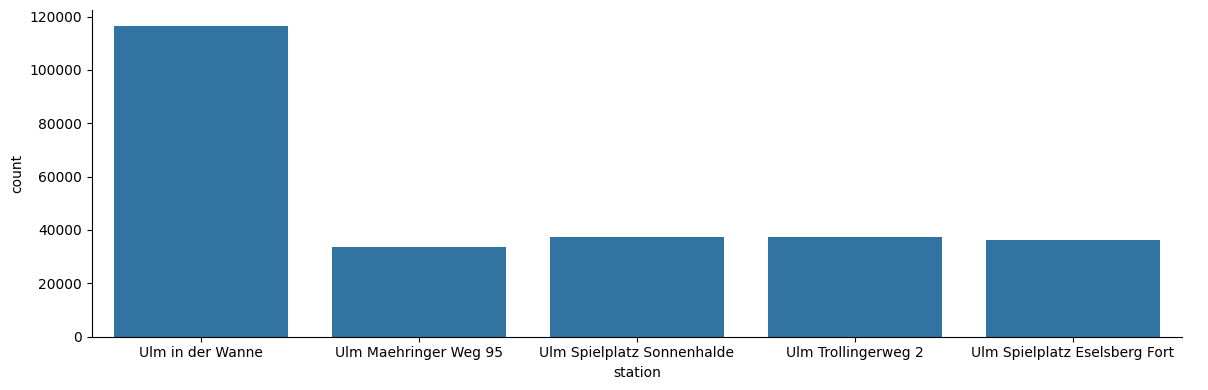

In [6]:
# Date ranges for each sensor
df_copy["date"] = pd.to_datetime(df_copy["date"], errors="ignore", dayfirst=True, format="%d/%m/%Y")
stations = df_copy["station"].unique().tolist()

for s in stations:
    selected = df_copy.loc[df_copy["station"] == s]
    selected["date"] = selected["date"].sort_values()
    
    min_val = selected.iloc[0, selected.columns.get_loc("date")]
    max_val = selected.iloc[-1, selected.columns.get_loc("date")]
    
    total = len(selected["station"])
    
    no2 = selected.loc[selected["pollutant"] == "NO2"]
    no2.dropna(inplace=True)
    no2 = len(no2)
    
    o3 = selected.loc[selected["pollutant"] == "O3"].value_counts()
    o3.dropna(inplace=True)
    o3 = len(o3)
    
    pm10 = selected.loc[selected["pollutant"] == "PM10"].value_counts()
    pm10.dropna(inplace=True)
    pm10 = len(pm10)
    
    pm25 = selected.loc[selected["pollutant"] == "PM2.5"].value_counts()
    pm25.dropna(inplace=True)
    pm25 = len(pm25)
    
    print(f"{s}:")
    print(f"  Date range: \n    {min_val} - {max_val}")
    print(f"  Total number of measurement values: \n    {total}")
    print(f"  Number of measurement values by pollutant: ")
    print(f"    NO2: {no2}\n    O3: {o3}\n    PM10: {pm10}\n    PM2.5: {pm25}\n\n")
    
    
plot = sns.catplot(x="station", kind="count", data=df_copy, height=4, aspect=3)

**Findings:** </br>
Since all sensors except "Ulm in der Wanne" were dismantled, more measured values are available from this location here. Even though the sensors from 4 other stations had the same runtime, they did not provide the same amount of measurement values. Also, for any reason about 900 PM2.5 measurement values are missing for "Ulm in der Wanne".

### Data Preparation

Based on the analysis of the data structure, I will only do a small data transformation and fill missing measurement values with the according mean value to avoid calculation issues.

In [7]:
df_modified = df_copy.copy()

df_modified = df_modified.pivot_table(index=["station", "date", "time"], 
                              columns="pollutant", 
                              values="value")
df_modified = df_modified.reset_index()
df_modified[df_modified.isna().any(axis=1)]

no2_mean = df_modified["NO2"].mean()
o3_mean = df_modified["O3"].mean()
pm10_mean = df_modified["PM10"].mean()
pm25_mean = df_modified["PM2.5"].mean()

df_modified["NO2"].fillna(value=no2_mean, inplace=True)
df_modified["O3"].fillna(value=o3_mean, inplace=True)
df_modified["PM10"].fillna(value=pm10_mean, inplace=True)
df_modified["PM2.5"].fillna(value=pm25_mean, inplace=True)

In [36]:
# Identify non-numeric values and negative values
non_numeric_counts = df_modified.applymap(lambda x: not pd.api.types.is_number(x)).sum()
negative_counts = df_modified.applymap(lambda x: x < 0 if pd.api.types.is_number(x) else False).sum()

# Combine the results into a single DataFrame for better readability
issue_counts = pd.DataFrame({
    'Non-numeric': non_numeric_counts,
    'Negative': negative_counts
})

# Print the issue counts
print("Number of non-numeric and negative values per column:")
print(issue_counts)

# Alternatively, if you only want to print the total counts
total_non_numeric = non_numeric_counts.sum()
total_negative = negative_counts.sum()

print(f"Total number of non-numeric values: {total_non_numeric}")
print(f"Total number of negative values: {total_negative}")

Number of non-numeric and negative values per column:
           Non-numeric  Negative
pollutant                       
station          65222         0
date             65222         0
time             65222         0
NO2                  0         0
O3                   0         0
PM10                 0         0
PM2.5                0         0
Total number of non-numeric values: 195666
Total number of negative values: 0


## Exploratory Data Analysis <a class="anchor" id="section4"></a>

Now that we have the data collected and wrangled, we"re ready to start exploring the data. In this section I will write some code to compute descriptive statistics from the data.

In [8]:
df_eda = df_modified.copy()
pollutants = ["NO2", "O3", "PM10", "PM2.5"]
stations = df_modified["station"].unique().tolist()

### 1. Statistics

First, let"s compute some basic counts. The cell below contains a function that iterates through the list of stations to calculate the number of times, when the pollutant limits were exceeded.</br>
**Findings:**</br>
- Pollutant limits are rarely exceeded at the measurement stations in Ulm
- Mostly PM measurements are exceeded, but only at Ulm Spielplatz Sonnenhalde

In [12]:
from typing import List

In [16]:
# Statistics about exceeded annual limits
# no2 annual: 40μg/m  hourly: 200μg/m
# o3 annual: 100μg/m  8-hourly average: 120μg/m
# pm10 annual: 40μg/m  daily: 50μg/m
# pm2.5 annual: 25μg/m  daily: 25μg/m


def get_count_exceeded_limits(df: pd.DataFrame, stations: List[str]) -> None:
    """
    Calculate and print the count and percentage of exceeded pollutant limits for each station.

    Parameters:
    df (pd.DataFrame): DataFrame containing pollutant data.
    stations (List[str]): List of station identifiers.
    """
    
    # Define the limit values
    limits = {
        'NO2_hourly': 200,
        'NO2_annual': 40,
        'O3_annual': 100,
        'PM10_daily': 50,
        'PM10_annual': 40,
        'PM2.5_daily': 25,
        'PM2.5_annual': 25
    }

    for station in stations:
        selected = df[df["station"] == station].copy()
        print(f"\nStation: {station}")
        print(f"{selected.describe()}\n")
        
        # Convert necessary columns to numeric
        pollutants = ["NO2", "O3", "PM10", "PM2.5"]
        for pollutant in pollutants:
            selected[pollutant] = pd.to_numeric(selected[pollutant], errors='coerce')
        
        # Hourly limits
        no2_exceeded_hourly = (selected["NO2"] >= limits['NO2_hourly']).sum()
        number_measurements_hourly = selected["NO2"].count()  # Use count to ignore NaNs
        no2_exceeded_hourly_percentage = (no2_exceeded_hourly / number_measurements_hourly) * 100
        
        # Daily limits
        selected_daily = selected.groupby("date")[pollutants].mean()
        pm10_exceeded_daily = (selected_daily["PM10"] >= limits['PM10_daily']).sum()
        pm25_exceeded_daily = (selected_daily["PM2.5"] >= limits['PM2.5_daily']).sum()
        number_measurements_daily = selected_daily.shape[0]
        pm10_exceeded_daily_percentage = (pm10_exceeded_daily / number_measurements_daily) * 100
        pm25_exceeded_daily_percentage = (pm25_exceeded_daily / number_measurements_daily) * 100
        
        # Annual limits
        selected["date"] = pd.to_datetime(selected["date"], errors="coerce")
        selected_annual = selected.groupby(selected["date"].dt.year)[pollutants].mean()
        no2_exceeded_annual = (selected_annual["NO2"] >= limits['NO2_annual']).sum()
        o3_exceeded_annual = (selected_annual["O3"] >= limits['O3_annual']).sum()
        pm10_exceeded_annual = (selected_annual["PM10"] >= limits['PM10_annual']).sum()
        pm25_exceeded_annual = (selected_annual["PM2.5"] >= limits['PM2.5_annual']).sum()
        number_measurements_annual = selected_annual.shape[0]
        no2_exceeded_annual_percentage = (no2_exceeded_annual / number_measurements_annual) * 100
        o3_exceeded_annual_percentage = (o3_exceeded_annual / number_measurements_annual) * 100
        pm10_exceeded_annual_percentage = (pm10_exceeded_annual / number_measurements_annual) * 100
        pm25_exceeded_annual_percentage = (pm25_exceeded_annual / number_measurements_annual) * 100

        print(f"""Count of hourly limits exceeded:
    \tNO2: {no2_exceeded_hourly} ({no2_exceeded_hourly_percentage:.2f}%)
    Count of daily limits exceeded:
    \tPM10: {pm10_exceeded_daily} ({pm10_exceeded_daily_percentage:.2f}%)
    \tPM2.5: {pm25_exceeded_daily} ({pm25_exceeded_daily_percentage:.2f}%)
    Count of annual limits exceeded:
    \tNO2: {no2_exceeded_annual} ({no2_exceeded_annual_percentage:.2f}%)
    \tO3: {o3_exceeded_annual} ({o3_exceeded_annual_percentage:.2f}%)
    \tPM10: {pm10_exceeded_annual} ({pm10_exceeded_annual_percentage:.2f}%)
    \tPM2.5: {pm25_exceeded_annual} ({pm25_exceeded_annual_percentage:.2f}%)\n""")


get_count_exceeded_limits(df_eda, stations)


Station: Ulm Maehringer Weg 95
pollutant          NO2           O3         PM10        PM2.5
count      8401.000000  8401.000000  8401.000000  8401.000000
mean         19.476015    30.568623    15.832520    10.048447
std           6.872785    16.351164     8.387571     5.945740
min           9.000000     0.000000     1.000000     0.000000
25%          15.000000    19.000000     9.000000     6.000000
50%          18.000000    30.000000    15.000000    10.000000
75%          23.000000    41.000000    21.000000    14.000000
max          64.000000   193.000000    80.000000    49.000000

Count of hourly limits exceeded:
    	NO2: 0 (0.00%)
    Count of daily limits exceeded:
    	PM10: 0 (0.00%)
    	PM2.5: 1 (0.28%)
    Count of annual limits exceeded:
    	NO2: 0 (0.00%)
    	O3: 0 (0.00%)
    	PM10: 0 (0.00%)
    	PM2.5: 0 (0.00%)


Station: Ulm Spielplatz Eselsberg Fort
pollutant          NO2           O3         PM10        PM2.5
count      9035.000000  9035.000000  9035.000000  9035.

### 2. General Pollutant Distribution Per Station

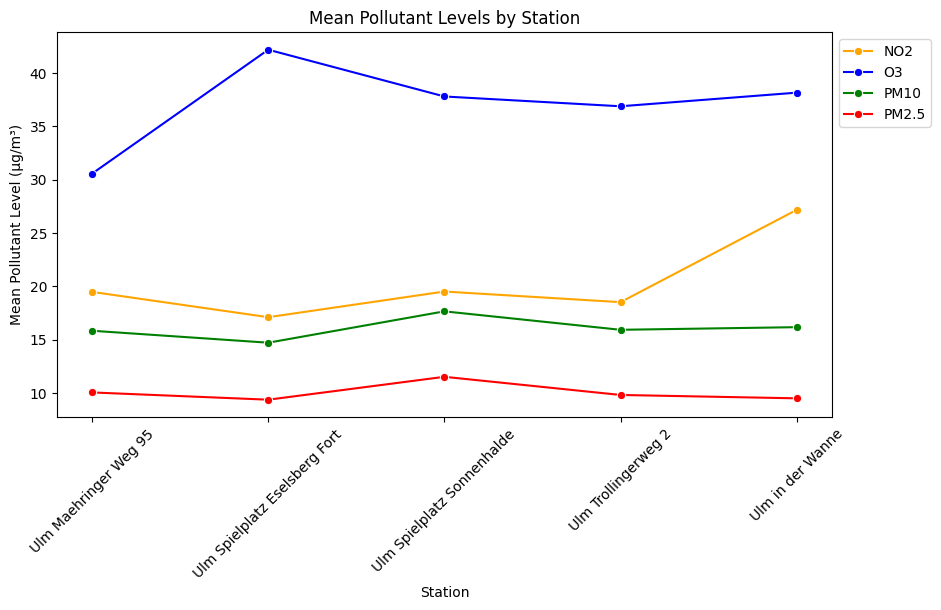

In [18]:
# Convert necessary columns to numeric
pollutants = ["NO2", "O3", "PM10", "PM2.5"]
for pollutant in pollutants:
    df_eda[pollutant] = pd.to_numeric(df_eda[pollutant], errors='coerce')

# Group by station and calculate the mean of each pollutant
mean_df = df_eda.groupby("station")[pollutants].mean().reset_index()

# Plot the mean values of pollutants for each station
plt.figure(figsize=(10, 5))
sns.lineplot(x="station", y="NO2", data=mean_df, color="orange", marker="o", label="NO2")
sns.lineplot(x="station", y="O3", data=mean_df, color="blue", marker="o", label="O3")
sns.lineplot(x="station", y="PM10", data=mean_df, color="green", marker="o", label="PM10")
sns.lineplot(x="station", y="PM2.5", data=mean_df, color="red", marker="o", label="PM2.5")

plt.legend(bbox_to_anchor=(1, 1))
plt.xticks(rotation=45)
plt.title("Mean Pollutant Levels by Station")
plt.xlabel("Station")
plt.ylabel("Mean Pollutant Level (µg/m³)")
plt.show()


### 3. Yearly Distribution

In [19]:
df_eda["date"] = pd.to_datetime(df_eda["date"], format="%d.%m.%Y")  # Convert the "date" column to datetime type
df_eda["month_year"] = df_eda["date"].dt.strftime("%m.%Y")  # Convert the "date" column to the "%m.%Y" format
df_eda["month_year"] = pd.to_datetime(df_eda["month_year"], format="%m.%Y")
df_eda["month_year"] = df_eda["month_year"].dt.strftime("%m.%Y")

In [23]:
def plot_distribution(df: pd.DataFrame) -> None:
    """
    Plot the distribution of pollutant levels for each station.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing pollutant data.
    """
    # Create the figure and subplots
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
    fig.suptitle("Yearly Pollution Distribution")

    # Plot boxplots for each pollutant
    sns.boxplot(x="station", y="NO2", data=df, ax=axs[0, 0]).set(title="NO2 Distribution")
    sns.boxplot(x="station", y="O3", data=df, ax=axs[0, 1]).set(title="O3 Distribution")
    sns.boxplot(x="station", y="PM10", data=df, ax=axs[1, 0]).set(title="PM10 Distribution")
    sns.boxplot(x="station", y="PM2.5", data=df, ax=axs[1, 1]).set(title="PM2.5 Distribution")

    for ax in fig.axes:
        plt.sca(ax)
        plt.xticks(rotation=45)

    plt.show()

In [24]:
def plot_yearly_distribution(df: pd.DataFrame, station: str) -> None:
    """
    Plot the monthly average pollutant levels for a given station.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing pollutant data.
    station (str): Station identifier.
    """
    df_station = df[df["station"] == station].copy()

    # Convert month_year to datetime and sort
    df_station["month_year"] = pd.to_datetime(df_station["month_year"], format="%m.%Y")
    df_station.sort_values(by="month_year", inplace=True)

    # Plot monthly average pollutant levels
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df_station, x="month_year", y="NO2", color="orange", marker="o", label="NO2")
    sns.lineplot(data=df_station, x="month_year", y="O3", color="blue", marker="o", label="O3")
    sns.lineplot(data=df_station, x="month_year", y="PM10", color="green", marker="o", label="PM10")
    sns.lineplot(data=df_station, x="month_year", y="PM2.5", color="red", marker="o", label="PM2.5")
    plt.title(f"Monthly Average Pollutant Distribution at {station}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

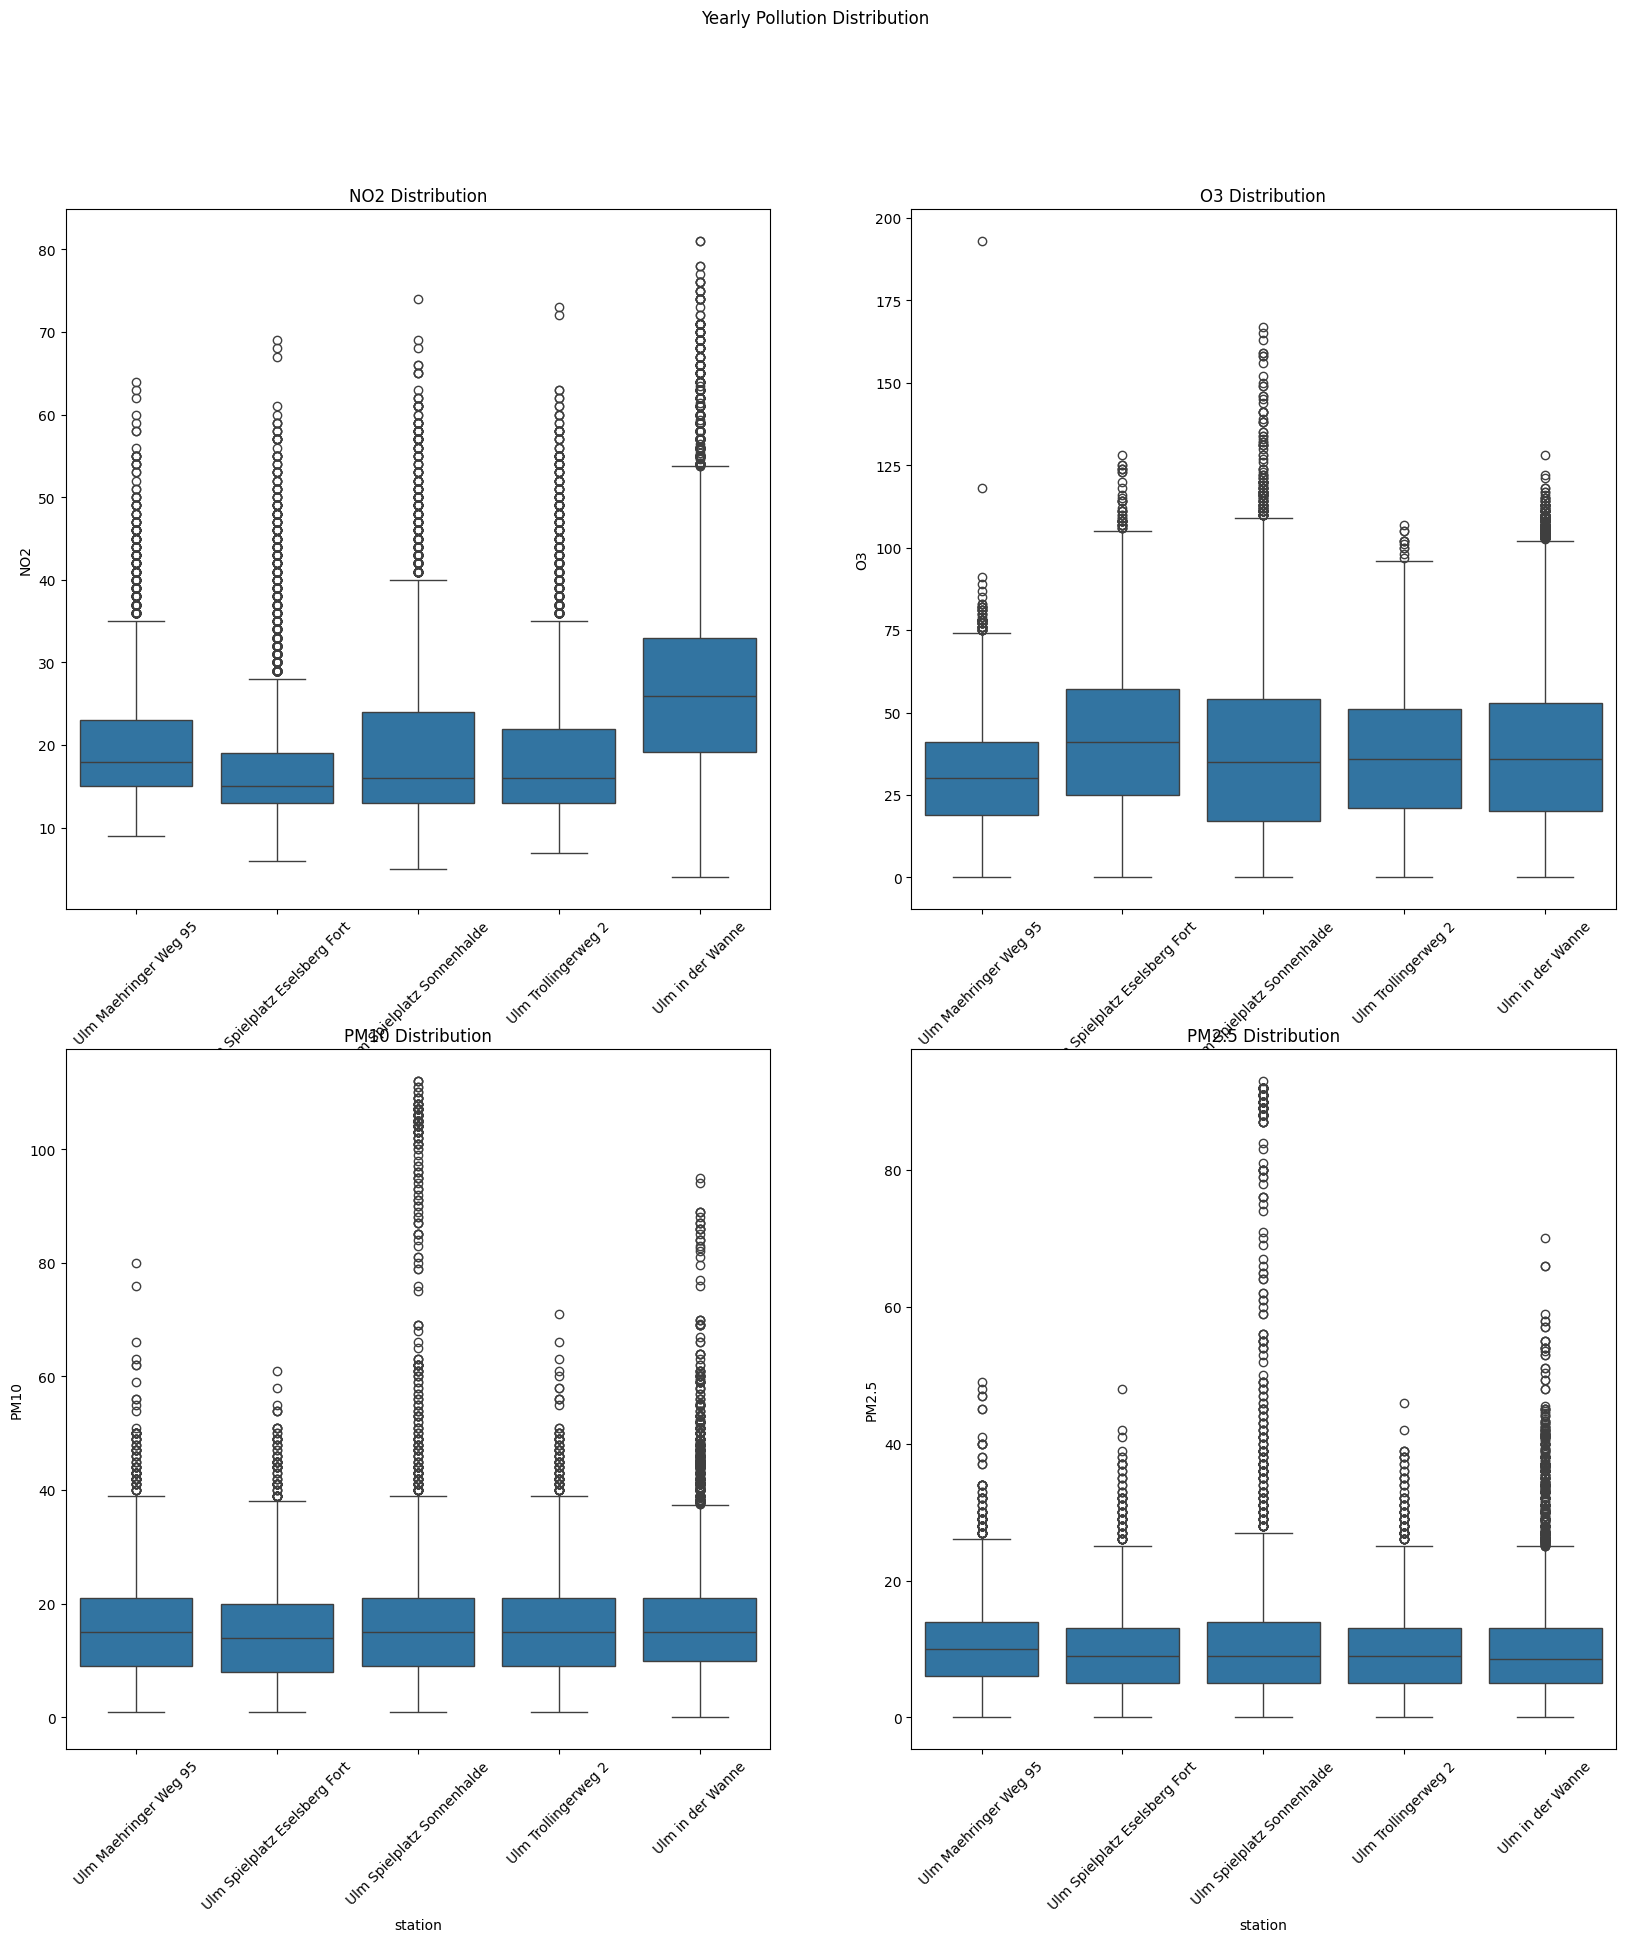

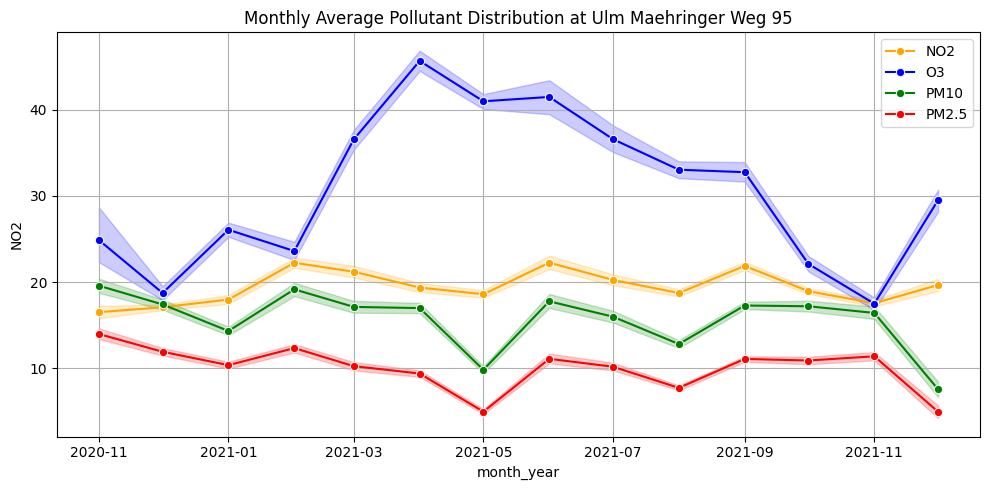

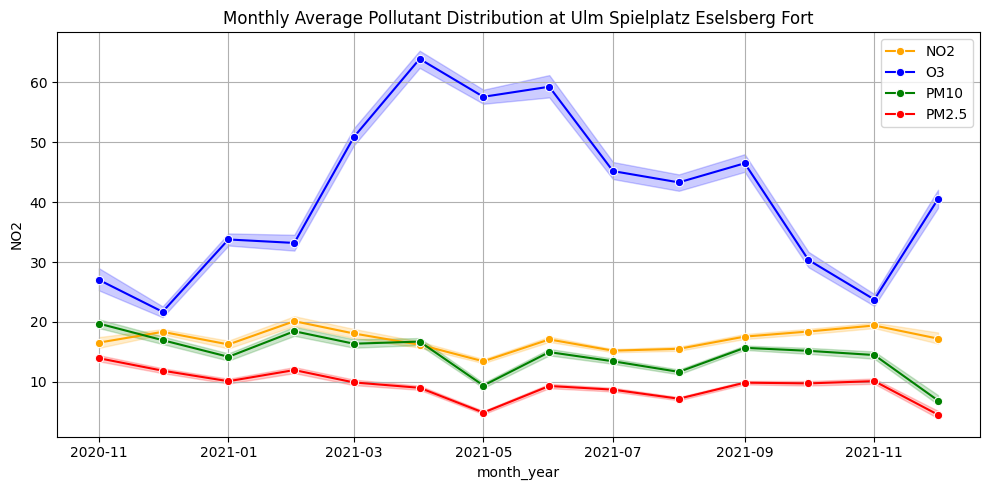

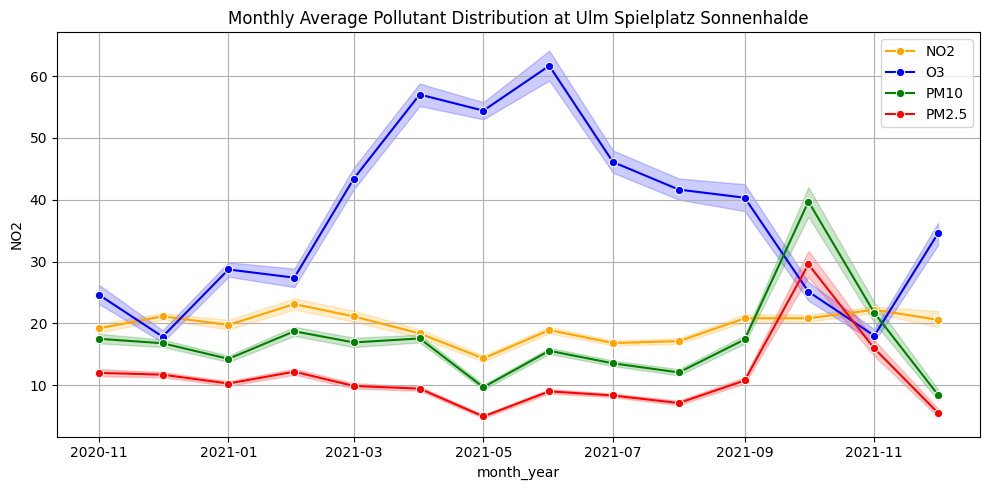

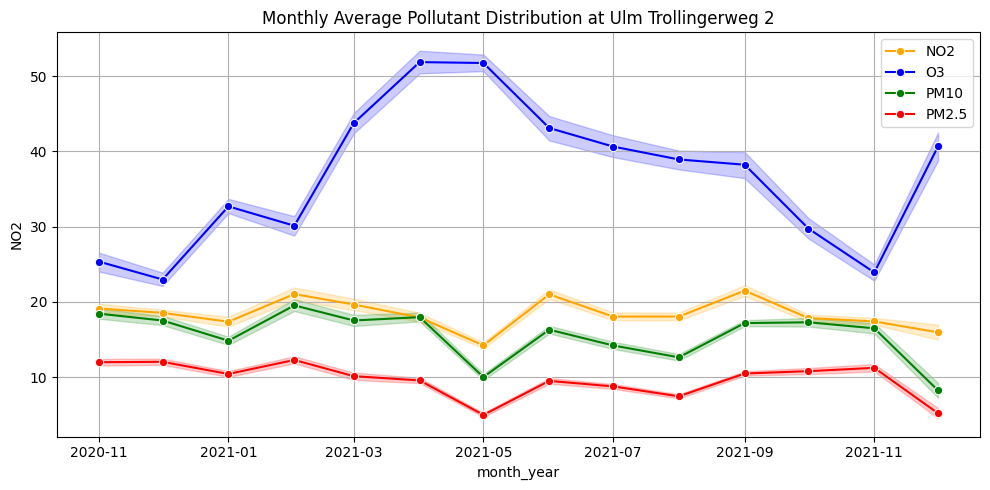

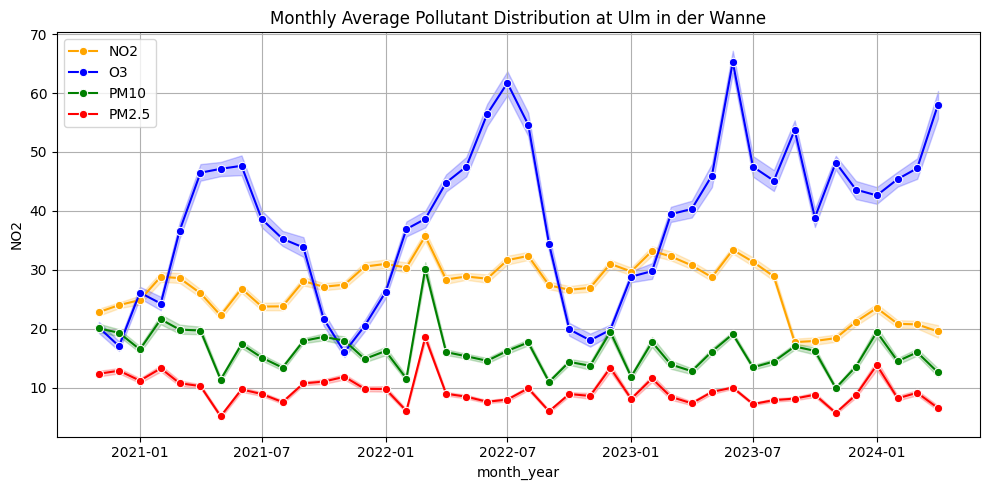

In [25]:
# Plot distribution of pollutants for all stations
plot_distribution(df_eda)

# List of stations
stations = df_eda["station"].unique()

# Plot yearly distribution for each station
for station in stations:
    plot_yearly_distribution(df_eda, station)

### 4. Daily Distribution
**Findings:**
- There is a visible trend correlated with daytime

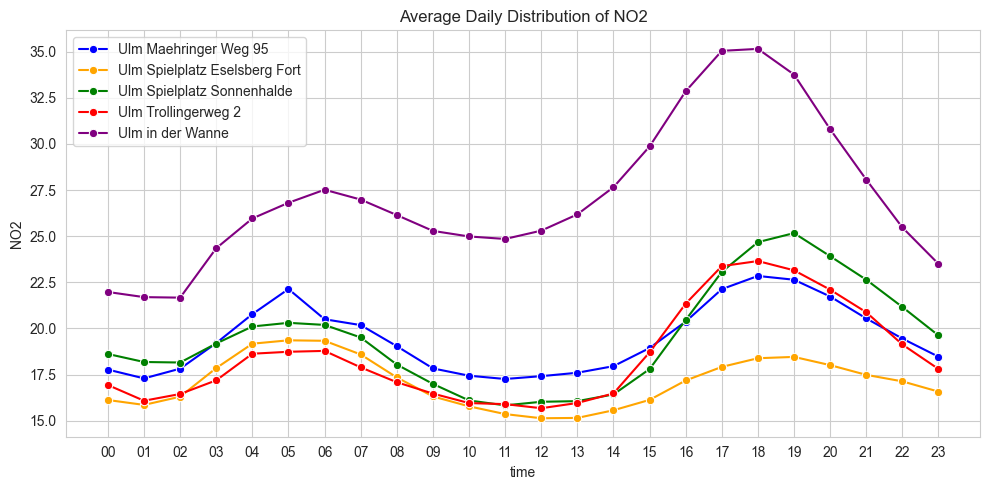

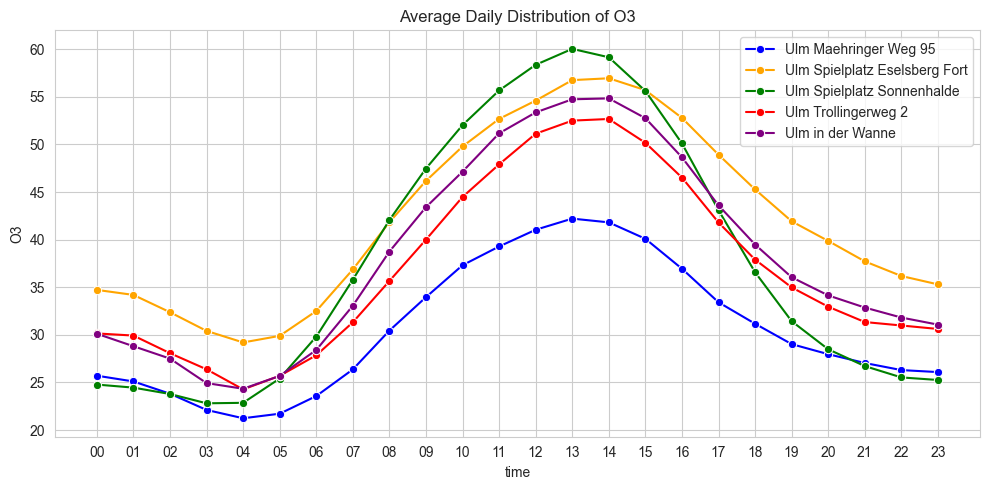

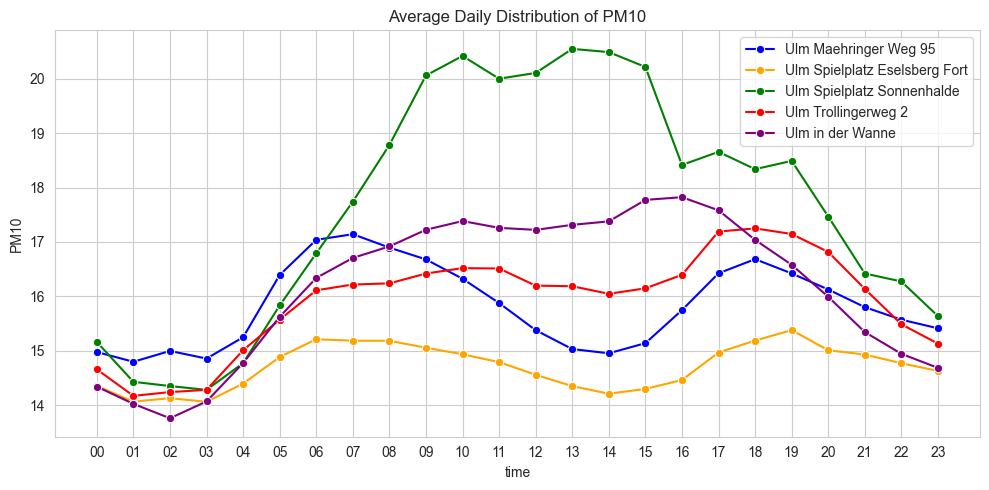

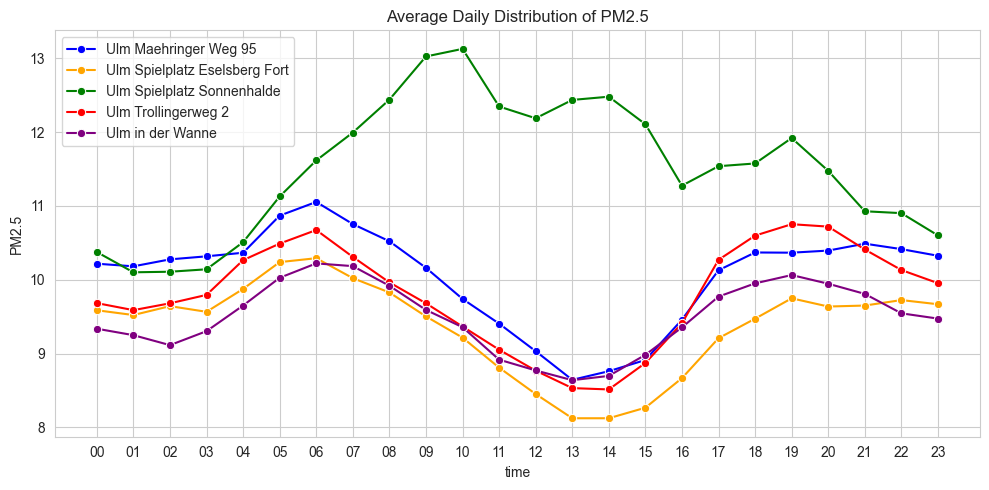

In [27]:
def plot_daily_distribution(df: pd.DataFrame, pollutant: str) -> None:
    """
    Plot the daily distribution of a specified pollutant for each station.

    Parameters:
    df (pd.DataFrame): DataFrame containing pollutant data.
    pollutant (str): The pollutant to plot.
    """
    df = df[["station", "time", pollutant]].groupby(["station", "time"]).mean().reset_index()

    color_map = {
        "Ulm Maehringer Weg 95": "blue",
        "Ulm Spielplatz Eselsberg Fort": "orange",
        "Ulm Spielplatz Sonnenhalde": "green",
        "Ulm Trollingerweg 2": "red",
        "Ulm in der Wanne": "purple"
    }

    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 5))
    plt.title(f"Average Daily Distribution of {pollutant}")

    for station, color in color_map.items():
        sns.lineplot(
            data=df[df["station"] == station],
            x="time",
            y=pollutant,
            color=color,
            marker="o",
            label=station
        )

    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot daily distribution for each pollutant
for p in pollutants:
    plot_daily_distribution(df_eda, p)

### 5. Yearly Distribution by Week
**Findings:**
- Pollutant limits got exceeded multiple times in certain weeks

In [28]:
def get_weekly_distribution(df, pollutant):
    
    df["date"] = pd.to_datetime(df["date"])
    df["week"] = df["date"].dt.isocalendar().week
    df_grouped = df.groupby(["station", "week"])
    df_pivot = df_grouped[pollutant].mean().reset_index().pivot(index="week", columns="station", values=pollutant)

    return df_pivot

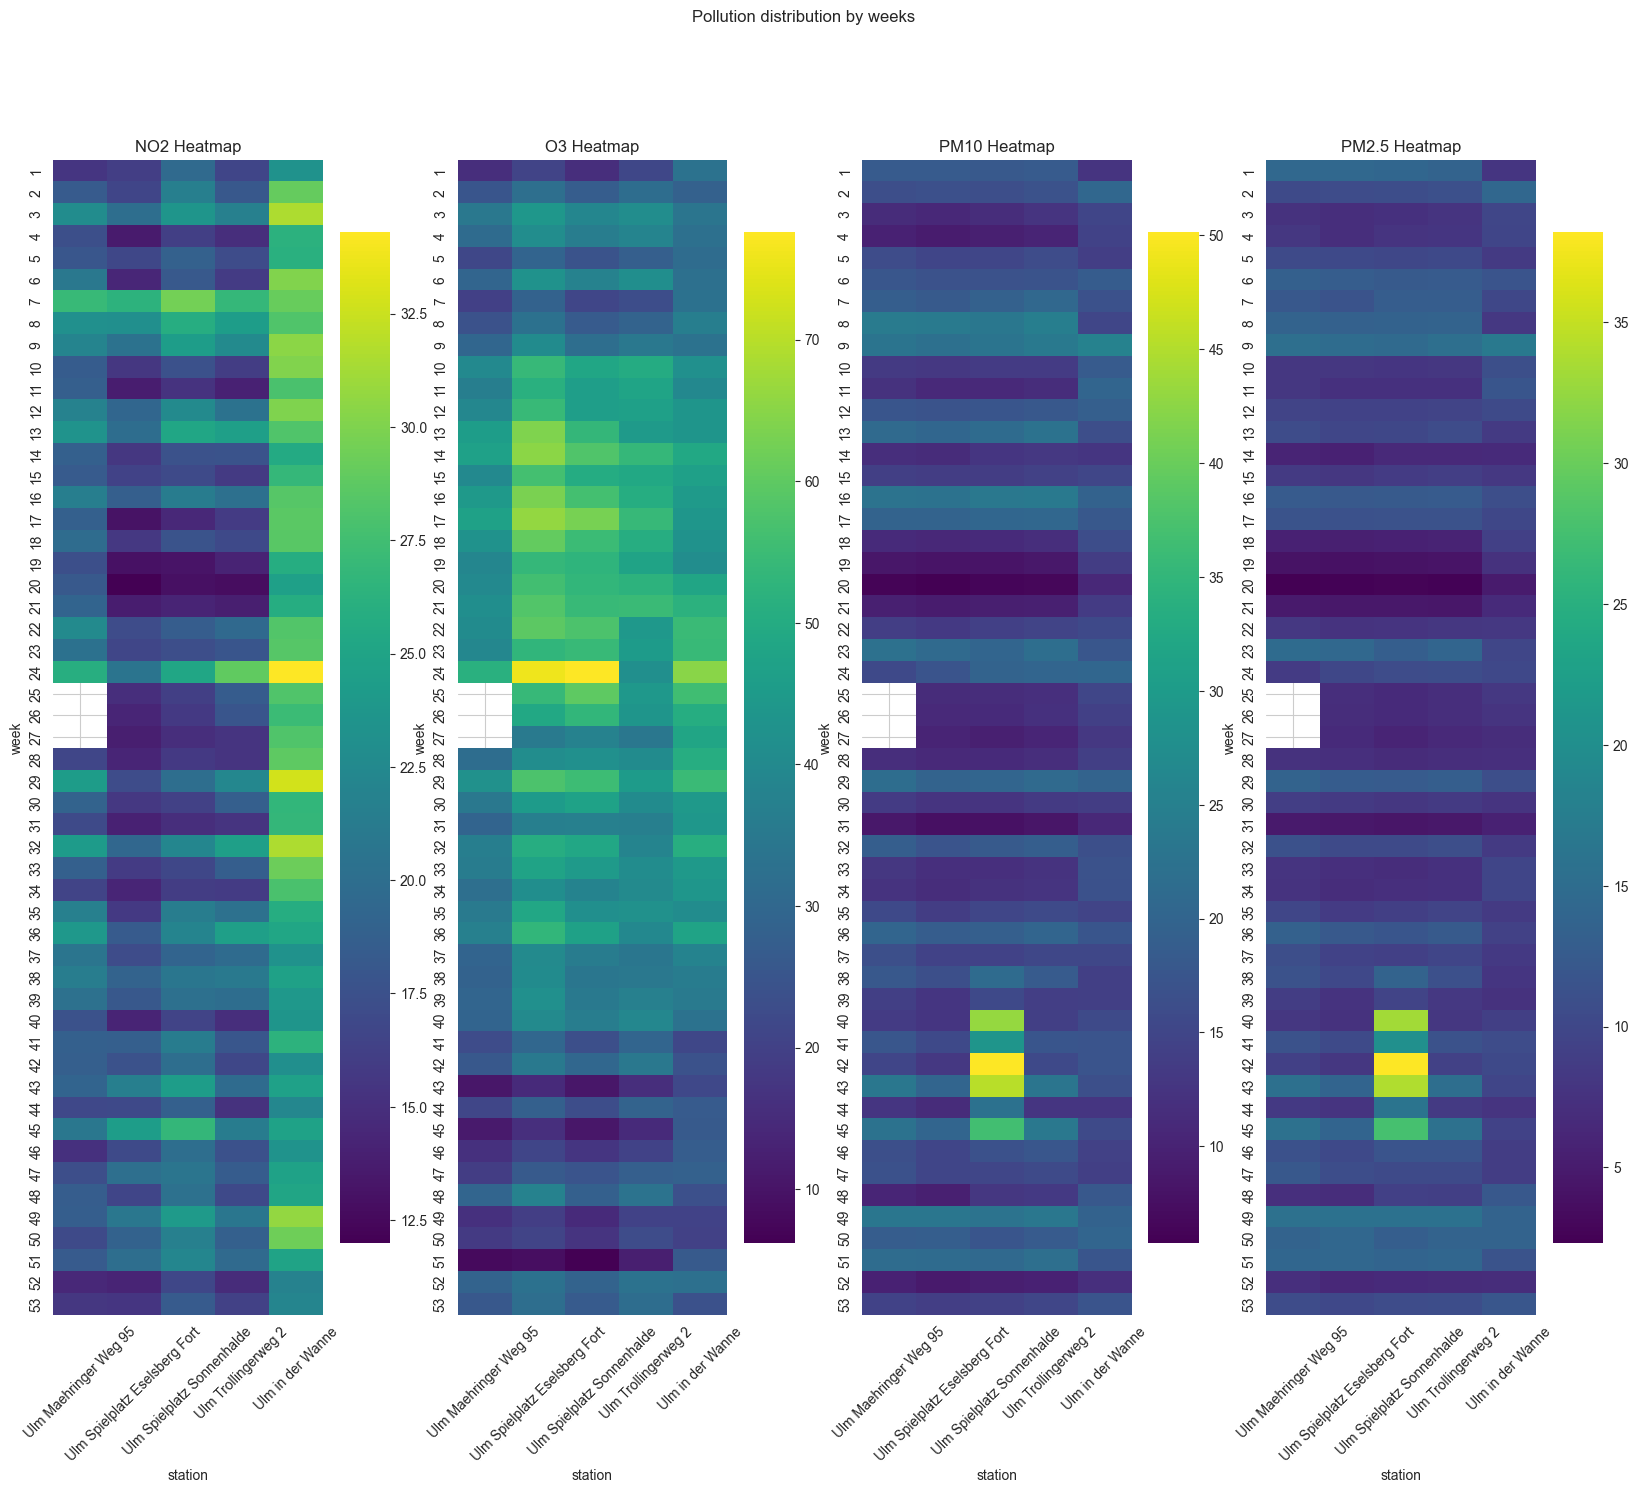

In [29]:
# Create the figure and subplots
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20,15))

fig.suptitle("Pollution distribution by weeks")

data1 = get_weekly_distribution(df_eda, "NO2")
data2 = get_weekly_distribution(df_eda, "O3")
data3 = get_weekly_distribution(df_eda, "PM10")
data4 = get_weekly_distribution(df_eda, "PM2.5")

# Plot the first heatmap
sns.heatmap(data1, cmap="viridis", ax=axs[0])
axs[0].set_title("NO2 Heatmap")

# Plot the second heatmap
sns.heatmap(data2, cmap="viridis", ax=axs[1])
axs[1].set_title("O3 Heatmap")

# Plot the third heatmap
sns.heatmap(data3, cmap="viridis", ax=axs[2])
axs[2].set_title("PM10 Heatmap")

# Plot the fourth heatmap
sns.heatmap(data4, cmap="viridis", ax=axs[3])
axs[3].set_title("PM2.5 Heatmap")

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

plt.show()

PM Values at "Ulm Spielplatz Sonnenhalde" are quite high in week 42 compared to the other weeks. </br>
The calendar week 42 in year 2021 from Monday, 18.10.2021
to Sunday, 24.10.2021.

In [31]:
# Filter the DataFrame for the selected date range and station
df_selected = df_eda.loc[(df_eda["date"] >= "18.10.2021") & 
                         (df_eda["date"] <= "24.10.2021") & 
                         (df_eda["station"] == "Ulm Spielplatz Sonnenhalde")]

# Convert the date column to datetime
df_selected["date"] = pd.to_datetime(df_selected["date"], format="%d.%m.%Y", errors="ignore")

# Group the data by date and calculate the mean for each pollutant
df_selected = df_selected.groupby("date")[["NO2", "O3", "PM10", "PM2.5"]].mean()
df_selected

pollutant,NO2,O3,PM10,PM2.5
date,,,,
2021-10-18,22.375000,10.958333,30.000000,20.416667
2021-10-19,22.708333,12.041667,54.875000,35.666667
2021-10-20,18.333333,38.958333,82.583333,68.458333
2021-10-21,13.583333,55.166667,71.250000,57.250000
2021-10-22,17.708333,43.375000,31.958333,24.041667
2021-10-23,22.000000,30.541667,36.833333,27.208333
2021-10-24,23.166667,18.208333,43.583333,34.500000


During the 42nd week of 2021 the PM limits got exceeded multiple times at station "Ulm Spielplatz Sonnenhalde".
In this time period were no public or school holidays.
Temperatures ranged from 6.4 - 18.6 degrees celsius on 20-10-2021. It was slightly colder in the two weeks prior. Source: https://www.dwd.de/

**PM10 Limits:** 24-hour average: 50 μg/m (EU and WHO limit)</br>
**PM2.5 Limits:** 24-hour average: 25 μg/m (WHO limit)

**Here are some further questions to explore:**</br>
- Do daily distributions differ by month or season? Which month has the highest pollutant measurements? Are there correlations to traffic, weather, events and/or geolocation?
- Is there a pattern of higher measurement values on the weekends versus weekdays? On which days are pollutant values more likely to be exceeded? 

Ulm Maehringer Weg 95
pollutant          NO2         O3       PM10      PM2.5
day_of_week                                            
Monday       19.214821  30.031640  15.537052   9.869276
Tuesday      19.376981  31.708924  15.528774   9.736447
Wednesday    20.600833  29.935833  16.231667  10.118333
Thursday     19.922816  31.301951  15.418151   9.545377
Friday       20.109477  30.363562  16.485294  10.213235
Saturday     19.121768  30.720601  15.765638  10.423686
Sunday       17.979149  29.935780  15.840701  10.421184



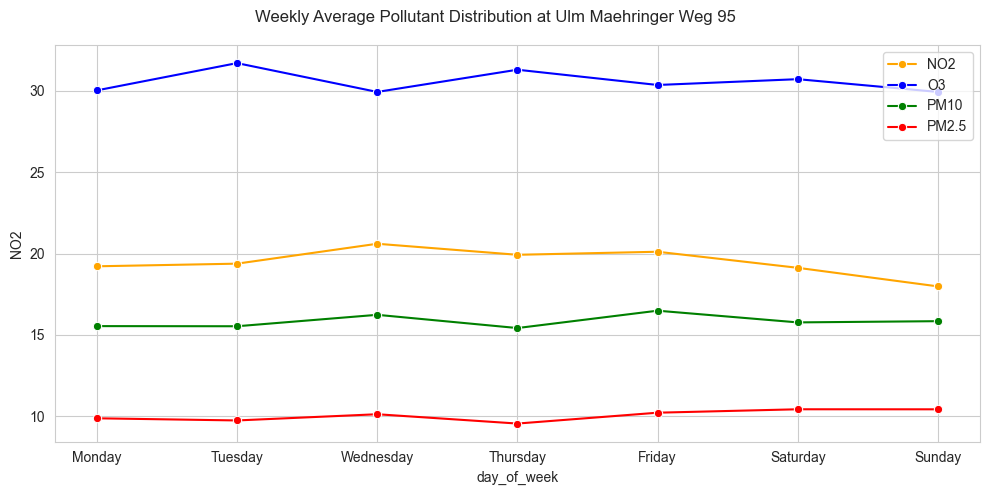

Ulm Spielplatz Eselsberg Fort
pollutant          NO2         O3       PM10     PM2.5
day_of_week                                           
Monday       16.924149  41.797988  14.096749  8.857585
Tuesday      16.682140  43.012589  14.444532  9.048780
Wednesday    17.955975  41.373428  14.922170  9.231918
Thursday     17.698868  42.864922  14.284260  9.001566
Friday       17.892424  42.056818  15.512121  9.732576
Saturday     16.948012  43.400612  14.928899  9.954893
Sunday       15.627799  40.803861  14.771429  9.722780



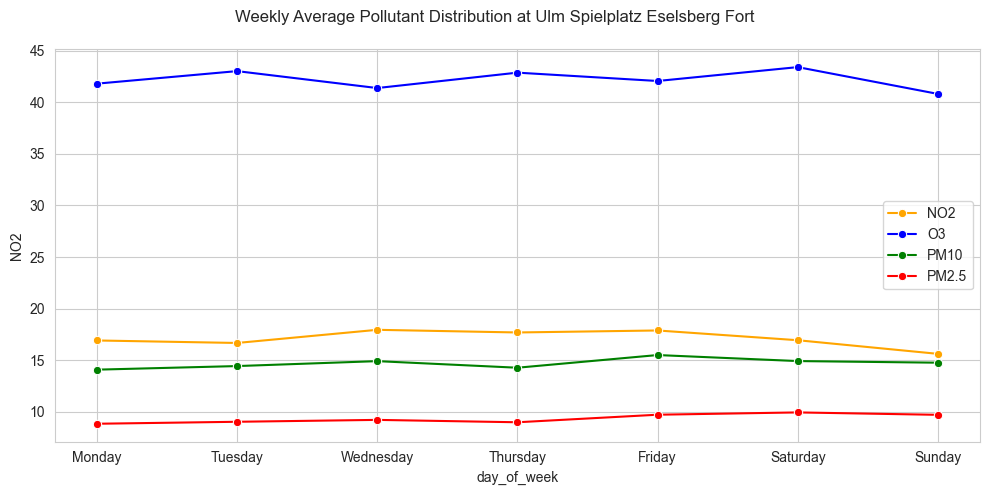

Ulm Spielplatz Sonnenhalde
pollutant          NO2         O3       PM10      PM2.5
day_of_week                                            
Monday       19.261194  37.491045  17.657463  11.610448
Tuesday      18.767248  38.797574  16.931008  10.792267
Wednesday    20.572403  36.636846  18.596664  12.025019
Thursday     20.160334  38.382219  17.553191  11.496201
Friday       20.301339  37.984375  17.430804  11.191964
Saturday     19.360863  38.805804  17.501488  11.556548
Sunday       18.166791  36.507074  17.897990  11.921817



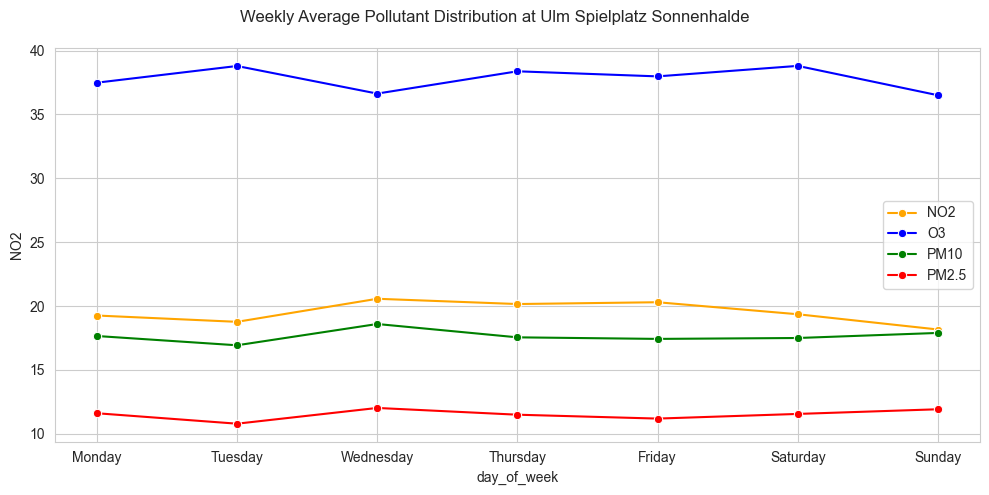

Ulm Trollingerweg 2
pollutant          NO2         O3       PM10      PM2.5
day_of_week                                            
Monday       18.222222  36.641141  15.462462   9.452703
Tuesday      17.955994  37.694234  15.528832   9.358877
Wednesday    19.542424  35.091667  16.281818   9.793939
Thursday     19.167933  36.909574  15.408815   9.420973
Friday       19.340030  36.720982  16.505952  10.104167
Saturday     18.437500  37.750744  16.406994  10.403274
Sunday       16.937688  37.346847  15.840090  10.129880



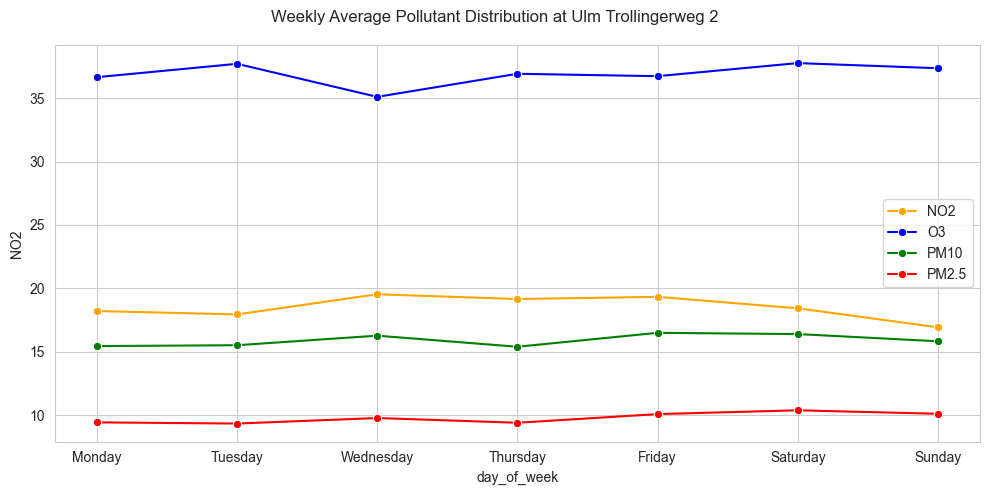

Ulm in der Wanne
pollutant          NO2         O3       PM10     PM2.5
day_of_week                                           
Monday       27.454744  38.476779  15.786779  9.241987
Tuesday      27.667782  37.983807  15.631920  9.063057
Wednesday    28.248947  37.136555  16.318722  9.558234
Thursday     28.329881  37.547918  16.710593  9.736351
Friday       28.135350  36.817801  16.805738  9.908399
Saturday     25.961674  39.468827  16.019587  9.567700
Sunday       24.393623  39.668329  15.912349  9.395106



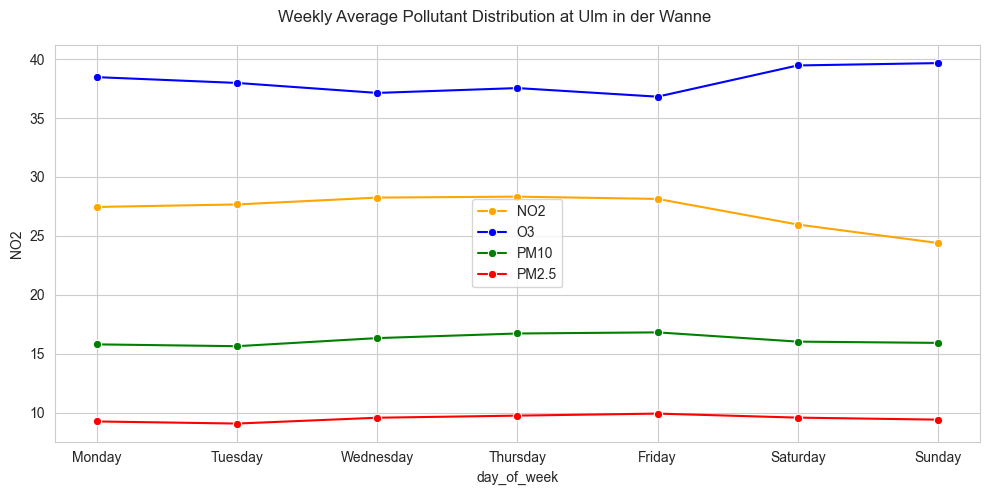

In [37]:
def explore_weekdays(df: pd.DataFrame, stations: List[str], pollutants: List[str]) -> None:
    """
    Print the mean pollutant values on each day for each station and plot the corresponding line graph.

    Parameters:
    df (pd.DataFrame): DataFrame containing pollutant data.
    stations (List[str]): List of station identifiers.
    pollutants (List[str]): List of pollutants to consider.
    """
    days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    for station in stations:
        selected = df[df["station"] == station].copy()
        selected["date"] = pd.to_datetime(selected["date"], errors="coerce")
        
        # Convert pollutants to numeric, ignoring errors
        for pollutant in pollutants:
            selected[pollutant] = pd.to_numeric(selected[pollutant], errors='coerce')
        
        # Group by day of the week and calculate mean values
        selected['day_of_week'] = selected['date'].dt.day_name()
        week_df = selected.groupby('day_of_week')[pollutants].mean().reindex(days)
        
        print(f"{station}")
        print(f"{week_df}\n")
    
        plt.figure(figsize=(10,5))
        for pollutant, color in zip(pollutants, ['orange', 'blue', 'green', 'red']):
            sns.lineplot(data=week_df, x=week_df.index, y=pollutant, color=color, err_style="bars", ci=0, marker="o")
        
        plt.suptitle(f"Weekly Average Pollutant Distribution at {station}")
        plt.legend(labels=pollutants)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


explore_weekdays(df_eda, stations, pollutants)

## Time Series Analysis

Since there is a larger number of measurements for Ulm in der Wanne, I will take a closer look at trends and seasonality at this station within this section.</br>
**Findings:**
- Only a slight trend of an NO2 and O3 increase is visible.
- PM measurements exceeded the limits in March 2021.

In [45]:
# Copy the dataframe and filter by station
df_tsa = df_eda.copy()
df_tsa = df_tsa.loc[df_tsa["station"] == "Ulm in der Wanne"]
df_tsa.drop(columns=["time", "station", "month_year", "week"], inplace=True)
df_tsa["date"] = pd.to_datetime(df_tsa["date"], format="%d.%m.%Y", errors="coerce")

# Convert pollutant columns to numeric, coercing errors to NaN
pollutants = ["NO2", "O3", "PM10", "PM2.5"]
for pollutant in pollutants:
    df_tsa[pollutant] = pd.to_numeric(df_tsa[pollutant], errors='coerce')

df_tsa.set_index("date", inplace=True)
df_tsa = df_tsa.groupby("date").mean()
df_tsa.head()

pollutant,NO2,O3,PM10,PM2.5
date,,,,
2020-11-13,21.375000,13.958333,21.083333,12.791667
2020-11-14,25.083333,17.791667,23.666667,13.958333
2020-11-15,22.958333,15.416667,22.291667,13.791667
2020-11-16,16.583333,36.125000,7.875000,3.000000
2020-11-17,23.125000,26.333333,13.458333,6.041667


In [46]:
def plot_distribution(df, pollutant, ax):
    data = df[pollutant]
    
    if pollutant == "NO2":
        color = "orange"
        threshold = 150
    elif pollutant == "O3":
        color = "blue"
        threshold = 100
    elif pollutant == "PM10":
        color = "green"
        threshold = 50
    elif pollutant == "PM2.5":
        color = "red"
        threshold = 25

    plt.figure(figsize=(12, 5))
    plot = ax.plot(data, color=color)
    ax.set_title(f"{pollutant} Distribution")
    ax.set(xlabel="Day", ylabel=f"{pollutant}")
    plt.tight_layout()
    ax.grid(True)
    
    #peaks = find_peaks(data, height=threshold)
    #ax.plot(data[peaks], "o")

In [51]:
def plot_moving_average(series, pollutant, window, ax, plot_intervals=False, scale=1.96):
    rolling_mean = series.rolling(window=window).mean()
    
    plot = ax.plot(rolling_mean, "g", label="Rolling mean trend", color="black")
    ax.set_title(f"{pollutant} Moving Average {window} Days")
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:], ax)
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
            
    plot = ax.plot(series[window:], label="Actual values")
    ax.legend(loc="best")

In [52]:
def exponential_smoothing(series, pollutant, alpha):
    
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result


def plot_exponential_smoothing(series, pollutant, alphas):
    plt.figure(figsize=(12, 5))
    for alpha in alphas:
        plt.plot(exponential_smoothing(series, pollutant, alpha), label="Alpha {}".format(alpha))
        
    plt.plot(series.values, "c", label="Actual", zorder=1)
    plt.legend(loc="best")
    plt.axis("tight")
    ax.set_title(f"{pollutant} Exponential Smoothing")

In [53]:
def plot_seasonality(df, pollutant):
    """
    This function creates a plot showing the pollutant distribution, 
    and the smoothed out values in the subplots below.
    """
    
    fig, axs = plt.subplots(figsize=(17,9))
    plt.axis("off")
    
    ax = fig.add_subplot(2, 1, 1)
    ax1 = fig.add_subplot(2, 2, 3)
    ax2 = fig.add_subplot(2, 2, 4)
    
    plot_distribution(df, pollutant, ax)
    
    #Smooth by the previous 30 days (month)
    plot_moving_average(df[pollutant], pollutant, 30, ax1)
    
    #Smooth by the previous 90 days (quarter)
    plot_moving_average(df[pollutant], pollutant, 90, ax2)
    
    #plot_exponential_smoothing(df[pollutant], pollutant, [0.05, 0.3])

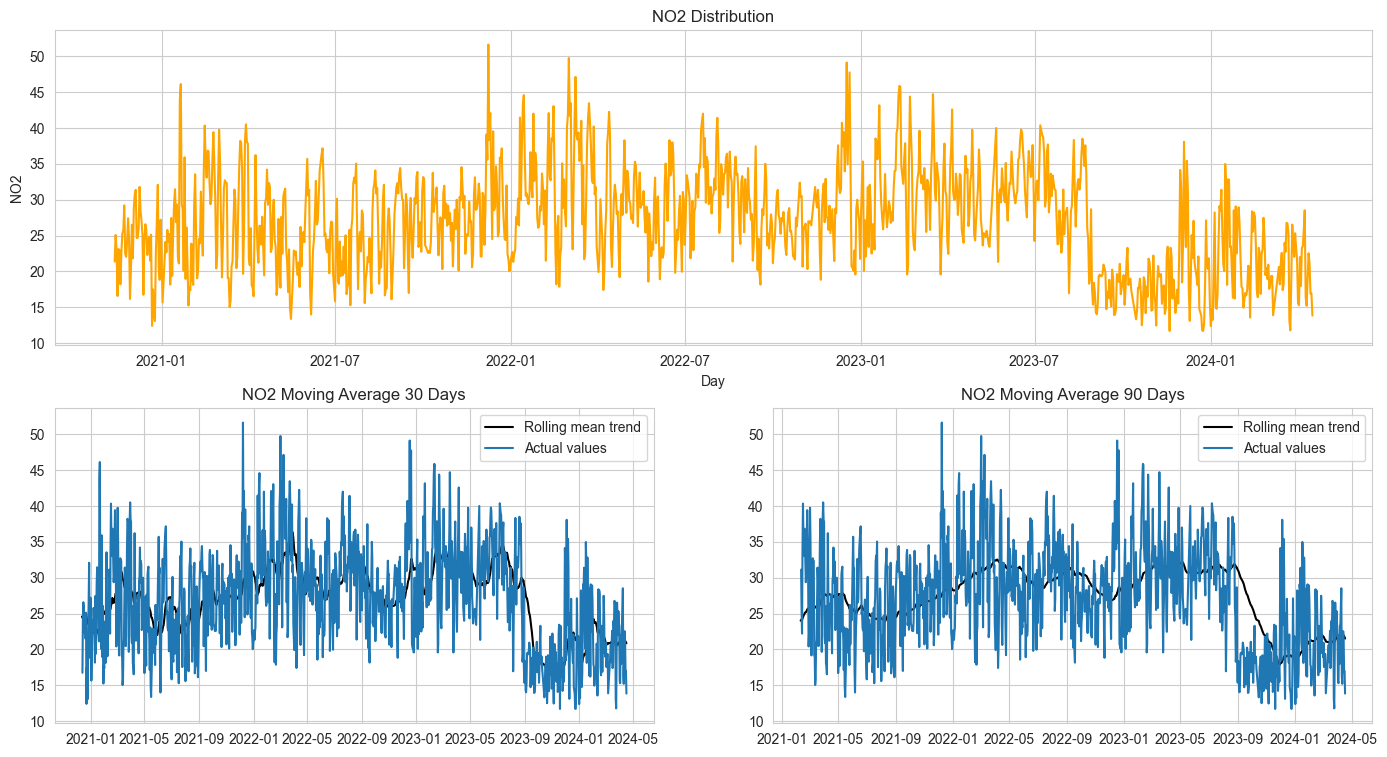

<Figure size 1200x500 with 0 Axes>

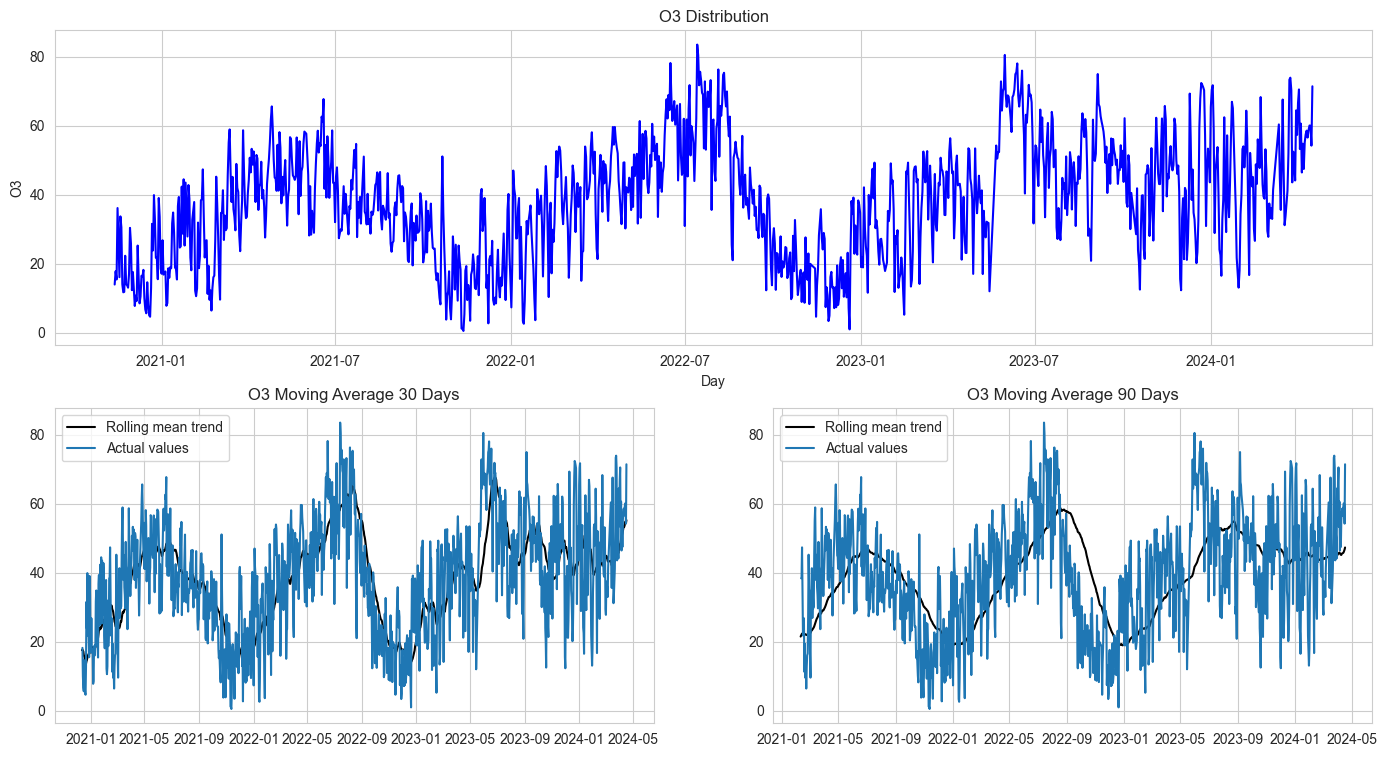

<Figure size 1200x500 with 0 Axes>

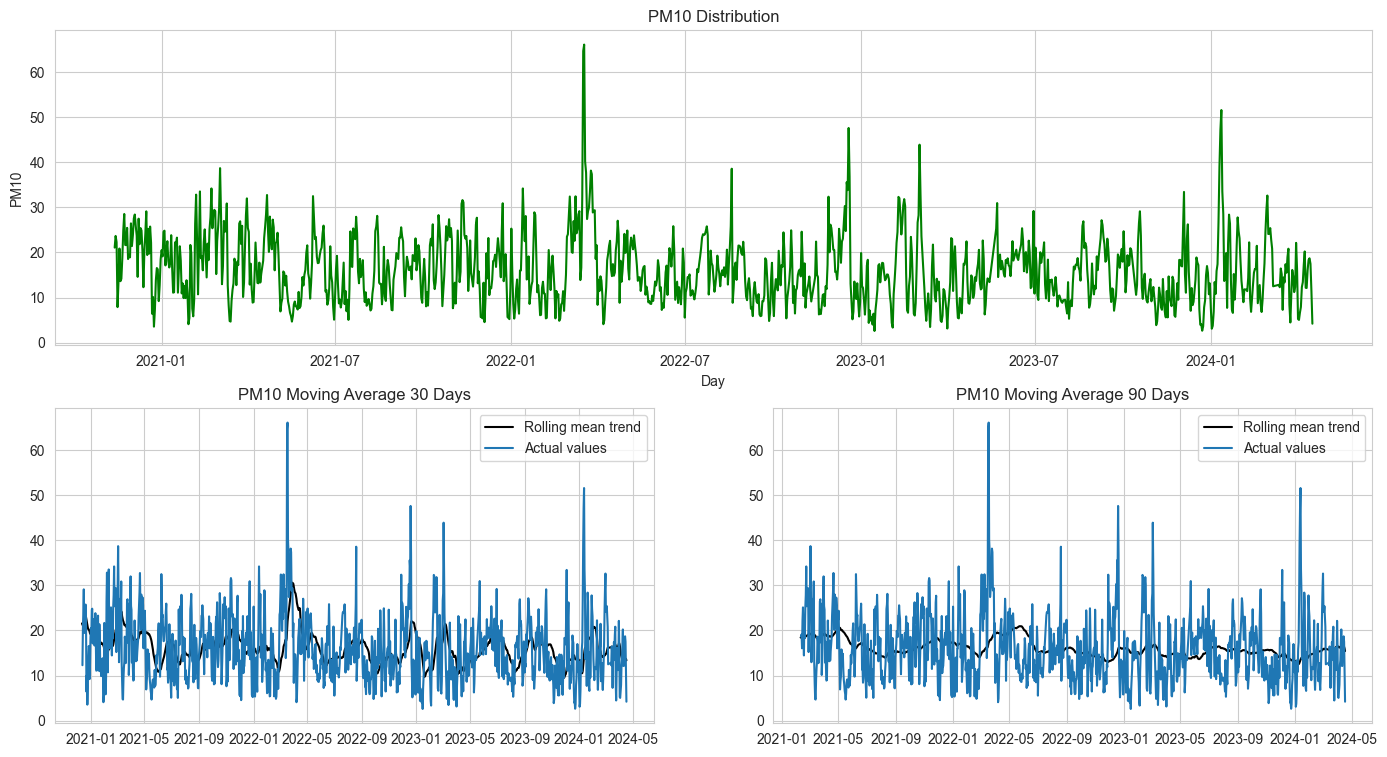

<Figure size 1200x500 with 0 Axes>

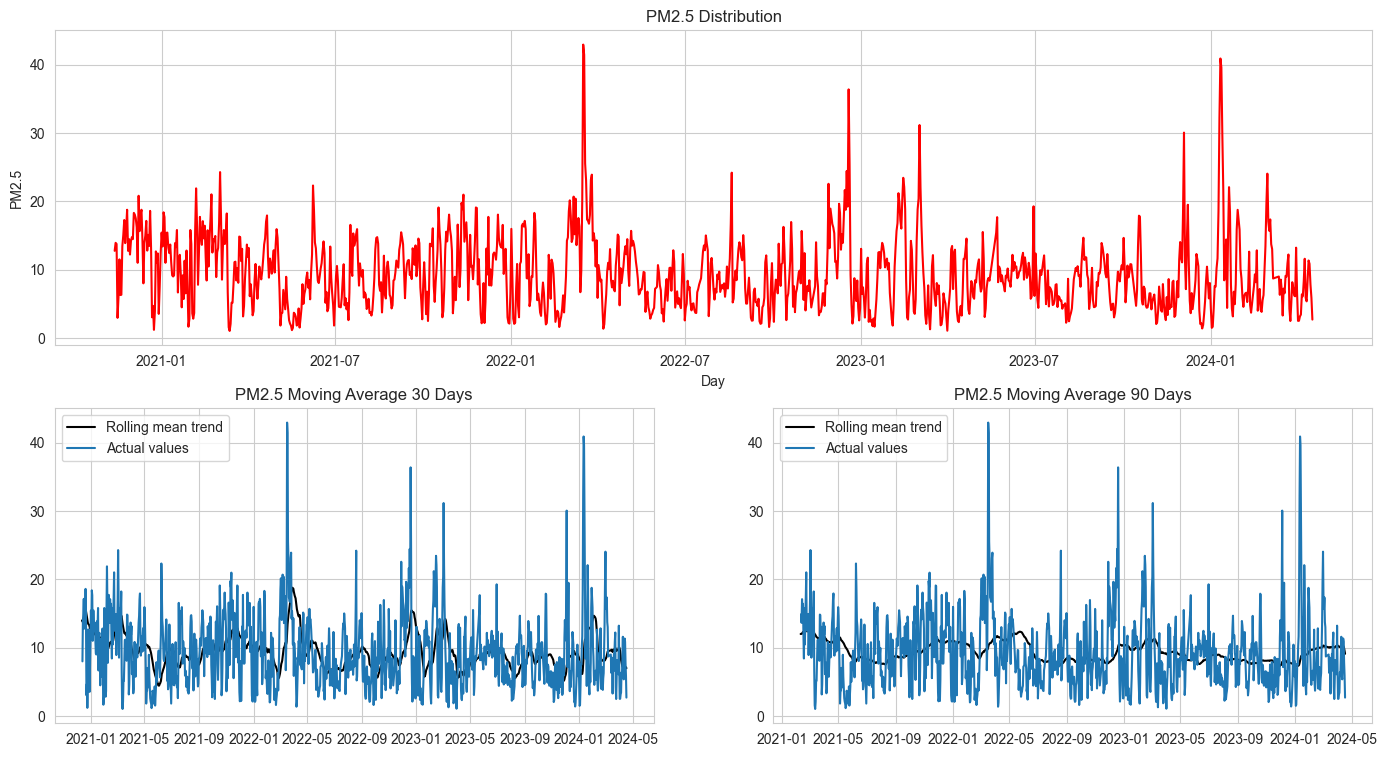

<Figure size 1200x500 with 0 Axes>

In [54]:
for p in pollutants:
    plot_seasonality(df_tsa, p)

In NO2, we observe a distribution shift for Ulm in der Wanne after September 2023, while the distributions of other pollutants remain consistent. Additionally, there is a noticeable seasonality in O3 levels.

## Evaluation

**Additional Insights and Future Directions**

The findings of the pollutant analysis present intriguing avenues for further exploration and research. Beyond the scope of this analysis, several potential areas warrant investigation to gain a deeper understanding of the dynamics influencing air quality.

**Exploring Correlations and Patterns**

One promising avenue is the examination of correlations between pollutant levels and various external factors, such as traffic density, meteorological conditions, public events, and geolocation. Understanding these relationships can provide valuable insights into the drivers of air pollution, facilitating targeted interventions to improve air quality. Additionally, investigating temporal patterns, such as variations in measurement values between weekends and weekdays or across different seasons, may reveal seasonal trends or behavioral factors that influence pollutant levels.

**Comparative Analysis with Similar Cities**

To contextualize the findings, it may be beneficial to conduct a comparative analysis with other similarly sized cities in Germany. This comparative approach could shed light on whether the observed low pollutant levels in Ulm are unique or part of a broader regional trend. Such comparisons could offer valuable benchmarking data for environmental policymakers and researchers.

**Data Sustainability Concerns**

While the analysis provides valuable insights, it is essential to acknowledge the potential fragility of the data ecosystem. As noted, the last sensor in Ulm may face decommissioning, and the sustainability of the data API is uncertain. This poses a challenge to the long-term viability of the pollutant analysis. To address this, we must consider strategies for data continuity, including the exploration of alternative data sources or collaborations with local authorities to ensure the availability of reliable air quality data.